In [20]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
import pandas as pd
from matplotlib import cm

data_path = Path('data')

In [10]:
train_df = pd.read_csv(data_path / 'PLAsTiCC-2018' / 'training_set.csv')

In [52]:
obj_id_arr = np.unique(train_df['object_id'])

In [57]:
def get_timeseries(id):
    sub_df = train_df.loc[train_df['object_id'] == id]
    obj_dict = {}
    for i in range(6):
        band_sub_df = sub_df.loc[sub_df['passband'] == i]
        obj_dict[i] = {
            'mjd': band_sub_df['mjd'].values.tolist(),
            'flux': band_sub_df['flux'].values.tolist(),
            'flux_err': band_sub_df['flux_err'].values.tolist(), 
            'detected': band_sub_df['detected'].values.tolist()
        }
    return obj_dict

test = get_timeseries(730)
# train_dict = dict(zip(obj_id_arr, [get_timeseries(id) for id in obj_id_arr]))

test_id = np.random.choice(obj_id_arr, size=5, replace=False)
test_dict = dict(zip(test_id, [get_timeseries(id) for id in test_id]))


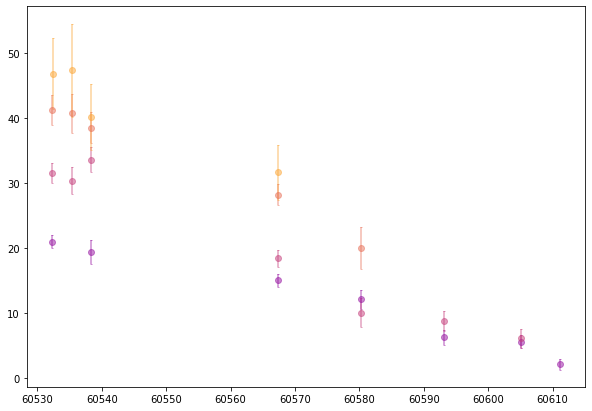

In [50]:
carr = np.linspace(0., 0.8, 6)
cmap = cm.get_cmap('plasma')

plt.figure(figsize=(10, 7))
for i in range(6):
    mask = np.asarray(test[i]['detected'], dtype=bool)
    plt.errorbar(
        np.asarray(test[i]['mjd'])[mask], np.asarray(test[i]['flux'])[mask], 
        yerr=np.asarray(test[i]['flux_err'])[mask],
        alpha=0.5, marker='o', capsize=1., ls='', color=cmap(carr[i])
    )

plt.show()

In [88]:
kern = 1. * Matern(length_scale=4., length_scale_bounds=[0.1, 100.], nu=2.5)

def gpr_fit(id, band):
    data = get_timeseries(id)[band]
    mask = np.asarray(data['detected'], dtype=bool)
    if not np.sum(mask): 
        print(f'No detected observations for object {id}, band {i}.')
        return None
    
    t_obs = np.asarray(data['mjd'])[mask]
    flux = np.asarray(data['flux'])[mask]
    flux_err = np.asarray(data['flux_err'])[mask]
    t0 = t_obs[np.argmax(flux)]
    t_obs -= t0

    gpr = GaussianProcessRegressor(kernel=kern, alpha=flux_err**2)
    gpr.fit(t_obs.reshape(-1, 1), flux.reshape(-1, 1))
    return gpr
    


In [95]:
t_gpr = np.linspace(-20., 90., 250)
model = gpr_fit(730, 3)

data = get_timeseries(730)[3]
mask = np.asarray(data['detected'], dtype=bool)
t_obs = np.asarray(data['mjd'])[mask]
flux = np.asarray(data['flux'])[mask]
flux_err = np.asarray(data['flux_err'])[mask]
t0 = t_obs[np.argmax(flux)]
t_obs -= t0

pred, err = model.predict(t_gpr.reshape(-1, 1), return_std=True)


21.3**2 * Matern(length_scale=77.2, nu=2.5)


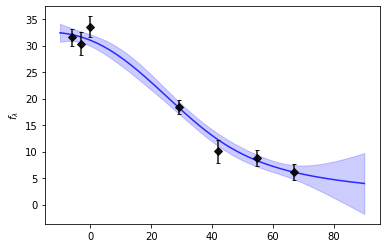

In [99]:
plt.figure(figsize=(6, 4))
plt.plot(
    t_gpr, pred, alpha=0.8, color='blue'
)
plt.errorbar(
    t_obs, flux, yerr=flux_err, color='black', marker='D', capsize=2., alpha=0.9, ls=''
)
plt.fill_between(
    t_gpr, pred.T[0] - err, y2=pred.T[0] + err, color='blue', alpha=0.2
)
plt.xlabel(r'$Days since maximum$')
plt.ylabel(r'$f_{\lambda}$')

plt.show()